## Data

#### store_attributes.csv
* ***store_id*** - store's unique identifier
* ***attribute_id*** - name of the store attribute
* ***attribute_type*** - data type of the attribute's value
* ***attribute_int_val*** - value of the store attribute if attribute_type is integer
* ***attribute_str_val*** - value of the store attribute if attribute_type is string
* ***attribute_float_val*** - value of the store attribute if attribute_type is float

#### transactions.csv
* ***date_week*** - start date of the 7-day week the row's cumulative revenue value represents
* ***store_id*** - store's unique identifier
* ***product_id*** - product's unique identifier
* ***currency_code*** - currency that the revenue is measured in
* ***revenue*** - the revenue from sale of a specified product for a specific store in a given week

#### products_of_interest.csv
* contains product id's of interest for exercise (more details below)

#### q3_treatment_stores.csv
* contains treatment store id's of interest for question 3 (more details below)

#### q3_control_stores.csv
* contains control store id's of interest for question 3 (more details below)


## Challenge

Suppose we have a client, Client X, that sells a variety of snacks and beverages at all of its stores. Client X suspects that by putting up new displays for Brand Z's candy, that consumers will purchase more of Brand Z's candy leading to higher revenue for candy. If Client X's intuition is correct, these new displays would lead to a multi-million dollar increase in total revenue across all stores; if they are incorrect, they will have wasted time and money putting up the new signs at best, and at worst they could see revenue from Brand Z's candy (or other candy brands) decrease. 

To mitigate this risk, Client X decides to conduct an experiment in a subset of stores first before making the decision to roll out the new signs to all stores. Client X enlists the help to devise an experiment to detect whether the new signs will result in a statistically significant increase in revenue from Brand Z's candy.

**Brand Z's candies are products (ids) listed in `products_of_interest.csv`**


### Question 1

Outline, **in words**, the steps of an experiment, from start to finish, to detect whether putting up new displays for Brand Z's candy will result in an increase in revenue from Brand Z's candy. Suppose your audience for this outline is the client, who has some general statistical understanding (i.e. you don't need to get into the weeds of any techniques/algorithms), but is looking to understand more thoroughly how this experiment will be set up and analyzed from enlisted help-- you, the expert data scientist.

### Question 1 Approach 

Situation:
Client X has a number of stores. Client X believes introducing brand Z will increase overall sales across all the stores.

Complication: 
This is a high-risk move. 

Resolution:
Need to test with a small test of stores to validate what the incremental revenue lift is going to be.

Approach:
We need to select a set of "test" stores where the brand Z will be introduced. We will then test if the incremental revenue is statistically significant or not. We will baseline it with the same store sales before the brand Z was introduced. 

If the test stores show statistically significant higher incremental revenue (lift) compared to the control stores, we will recommend introducing brand Z across all of the stores.

### Question 2
One challenge in offline (brick and mortar) A/B testing compared to online A/B testing is that randomization is not possible at the customer level. Consequently, alternative methods must be used in choosing treatment and control groups. One way to overcome this challenge is to test at the store level and strategically select sets of stores to use as treatment and control groups. 

Utilizing data and your statistical expertise, how could we intelligently improve upon random selection to obtain (1) a set of treatment stores that better represents the complete set of stores to which we want to roll out the changes and (2) a set of control stores that are a better baseline for our experiment? Which exact stores (by id) would you use in the control group and which in the treatment group for this experiment? Please explain how you came to this decision (e.g. methodology, algorithms, assumptions, etc.). Assume the data we've provided contains all stores.

### Question 2 Approach 

Assumption: There are different kinds of stores (Eg: total area, location etc). 

We need to ensure the distribution of the different kinds of stores have similar distribution in both Test and Control.

Given the current data, I would cluster the stores based on the attributes. 

I would use stratified sampling method.

I would then do a 50% random selection from each of the clusters for test and remaining would be control.

In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.cluster import KMeans

from scipy.stats import ttest_ind

In [153]:
brandz = pd.read_csv('products_of_interest.csv', header=None) # Brand Z candies
transaction = pd.read_csv('transactions.csv') 
control = pd.read_csv('q3_control_stores.csv', header=None)
treatment = pd.read_csv('q3_treatment_stores.csv', header=None)
attributes = pd.read_csv('store_attributes.csv')


In [3]:
transaction.shape

(1048575, 6)

In [4]:
attributes.shape

(16538, 7)

In [5]:
brandz.shape

(502, 1)

In [6]:
control.shape

(25, 1)

In [7]:
treatment.shape

(25, 1)

# EDA

In [8]:
attributes.head()

,Unnamed: 0,store_id,attribute_id,attribute_type,attribute_int_val,attribute_str_val,attribute_float_val
0,0,631,8,float,NaN,NaN,9447217.69
1,1,501,8,float,NaN,NaN,8807968.29
2,2,486,8,float,NaN,NaN,4038617.13
3,3,392,8,float,NaN,NaN,12222048.62
4,4,561,8,float,NaN,NaN,4298550.49


In [9]:
attributes.count()

Unnamed: 0             16538
store_id               16538
attribute_id           16538
attribute_type         16538
attribute_int_val        674
attribute_str_val       1348
attribute_float_val    14516
dtype: int64

In [10]:
attributes.dtypes

Unnamed: 0               int64
store_id                 int64
attribute_id             int64
attribute_type          object
attribute_int_val      float64
attribute_str_val       object
attribute_float_val    float64
dtype: object

In [11]:
attributes.attribute_type.unique()

array(['float', 'integer', 'string'], dtype=object)

In [12]:
attributes.isnull().sum()

Unnamed: 0                 0
store_id                   0
attribute_id               0
attribute_type             0
attribute_int_val      15864
attribute_str_val      15190
attribute_float_val     2022
dtype: int64

In [13]:
len(attributes[attributes.attribute_type=='string'])

1348

In [14]:
len(attributes[attributes.attribute_type=='integer'])

674

In [15]:
len(attributes[attributes.attribute_type=='float'])

14516

In [16]:
# total number of unique stores = 337

(attributes.store_id.unique())

array([631, 501, 486, 392, 561, 654, 460, 582, 369, 442, 619, 384, 614,
       656, 446, 564, 350, 588, 458, 427, 639, 581, 526, 391, 441, 430,
       493, 379, 617, 497, 565, 348, 519, 416, 625, 635, 424, 354, 514,
       417, 404, 470, 516, 362, 575, 372, 387, 537, 633, 518, 355, 548,
       531, 443, 536, 592, 361, 538, 553, 498, 552, 352, 479, 453, 560,
       615, 451, 500, 456, 648, 540, 576, 569, 414, 636, 365, 638, 439,
       344, 363, 586, 473, 671, 374, 485, 539, 499, 356, 660, 672, 447,
       510, 622, 643, 436, 505, 471, 412, 431, 339, 454, 343, 455, 637,
       380, 457, 662, 428, 360, 409, 529, 571, 448, 368, 346, 605, 550,
       381, 494, 366, 556, 477, 489, 630, 612, 383, 459, 472, 543, 440,
       675, 628, 496, 598, 567, 645, 669, 573, 423, 585, 376, 558, 425,
       482, 650, 464, 463, 534, 616, 462, 600, 613, 382, 378, 403, 433,
       673, 373, 402, 475, 603, 644, 388, 406, 532, 642, 342, 396, 377,
       577, 621, 503, 492, 370, 504, 653, 515, 547, 641, 632, 66

In [17]:
(attributes[attributes.attribute_type=='string']['attribute_str_val']).unique()


array(['Unknown', 'New & Closed Stores', 'ID', '***CLOSED***ID-BOISE-004',
       'White Water', 'ID-BOISE-006', 'COUNTRY', 'Big Snow', 'MT',
       'MT-BRIDGER-007', 'ADVENTURE ', 'Canyon', 'UT', 'UT-BOUNTIFUL-130',
       'NV', '***CLOSED***NV-WINNEMUCCA-134', 'WY', 'WY-SHERIDAN-135',
       'WY-LYMAN-136', 'UT-CENTERVILLE-145', '***CLOSED***ID-RIGBY-152 ',
       '***CLOSED***ID-ST. ANTHONY-155', 'ID-RIRIE-156',
       'WY-EVANSTON-162', '***CLOSED***WY-GILLETTE-165', 'WY-WORLAND-166',
       'UT-BOUNTIFUL-168', '***CLOSED***ID-REXBURG-169',
       'ID-BLACKFOOT-172', '***CLOSED***ID-BOISE-175', 'ID-ABERDEEN-177',
       'ID-NAMPA-178', 'UT-PROVIDENCE-181', 'UT-LAYTON-184',
       '***CLOSED***ID-IDAHO FALLS-185', '***CLOSED***WY-THERMOPOLIS-187',
       'WY-RIVERTON-192', 'WY-RIVERTON-193', 'ID-POCATELLO-194',
       'ID-REXBURG-195', 'UT-MIDVALE-196', 'UT-LAYTON-197',
       'ID-BOISE-198', 'UT-SALT LAKE-199', 'Red Rock', 'AZ',
       'AZ-LAKE HAVASU-201', 'WY-CODY-202', 'ID-KIMBE

In [18]:
(attributes[attributes.attribute_str_val=='ID-MERIDIAN-343']['attribute_str_val']).count()

1

<AxesSubplot:xlabel='count', ylabel='attribute_str_val'>

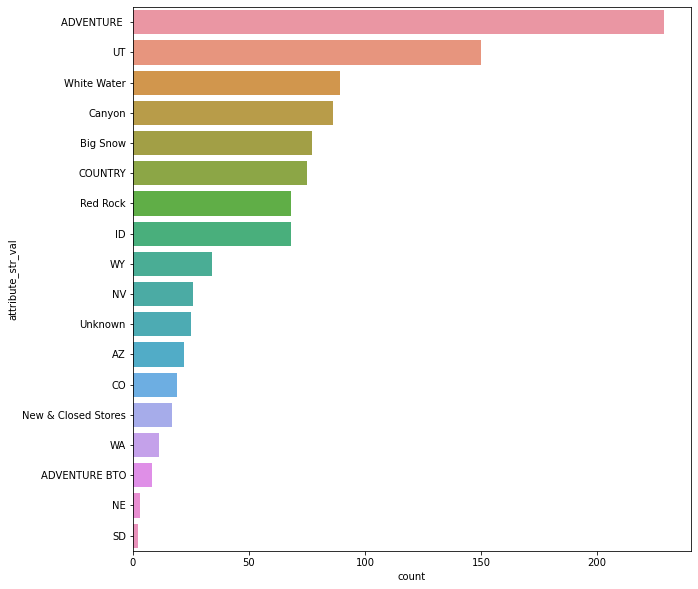

In [19]:
plt.figure(figsize =(10,10))

#  order=attributes.attribute_str_val.value_counts().iloc[:20].index

sns.countplot(y = 'attribute_str_val', data = attributes, order=attributes.attribute_str_val.value_counts().iloc[:18].index)

#for i, v in enumerate(attributes['attribute_str_val']):
#    plt.text(value, index, str(value))

#plt.show()


In [20]:
# find percentage of first 4 values

attributes[attributes.attribute_str_val=='Big Snow'].shape



(77, 7)

In [21]:
150+ 89+

SyntaxError: invalid syntax (<ipython-input-21-9816fd56d196>, line 1)

In [22]:
attributes.to_csv('attributes.csv')

<AxesSubplot:xlabel='count', ylabel='attribute_str_val'>

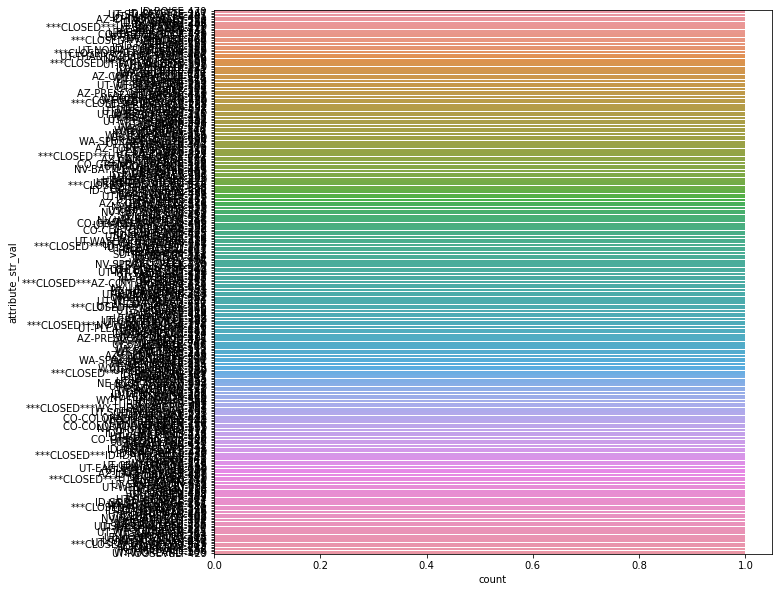

In [23]:
plt.figure(figsize =(10,10))


sns.countplot(y = 'attribute_str_val', data = attributes, order=attributes.attribute_str_val.value_counts().iloc[19:].index)


In [24]:
(attributes[attributes.attribute_str_val=='New & Closed Stores']).count()


Unnamed: 0             17
store_id               17
attribute_id           17
attribute_type         17
attribute_int_val       0
attribute_str_val      17
attribute_float_val     0
dtype: int64

In [25]:
attributes[attributes.store_id==390]

,Unnamed: 0,store_id,attribute_id,attribute_type,attribute_int_val,attribute_str_val,attribute_float_val
7184,7184,390,13,float,NaN,NaN,17.0700
7185,7185,390,22,float,NaN,NaN,20.6800
7186,7186,390,6,float,NaN,NaN,15.0000
7187,7187,390,34,float,NaN,NaN,514.4100
7188,7188,390,1,float,NaN,NaN,3042.9100
7189,7189,390,41,float,NaN,NaN,1864.7000
7190,7190,390,30,float,NaN,NaN,241.1300
7191,7191,390,14,float,NaN,NaN,89.7022
7192,7192,390,42,float,NaN,NaN,38.7900
7193,7193,390,33,float,NaN,NaN,29451.0000


In [26]:
attributes[attributes.store_id==526]

,Unnamed: 0,store_id,attribute_id,attribute_type,attribute_int_val,attribute_str_val,attribute_float_val
22,22,526,8,float,NaN,NaN,7.312687e+06
327,327,526,18,float,NaN,NaN,2.280500e+00
569,569,526,21,float,NaN,NaN,6.190000e-02
586,586,526,45,float,NaN,NaN,8.381780e+01
1032,1032,526,20,float,NaN,NaN,7.051000e-01
1199,1199,526,44,float,NaN,NaN,8.934000e-01
1720,1720,526,17,float,NaN,NaN,4.420900e+00
1834,1834,526,3,float,NaN,NaN,1.162000e-01
1892,1892,526,4,float,NaN,NaN,1.420000e-01
2251,2251,526,26,float,NaN,NaN,8.920000e-02


In [27]:
attributes[attributes.store_id==349]

,Unnamed: 0,store_id,attribute_id,attribute_type,attribute_int_val,attribute_str_val,attribute_float_val
249,249,349,8,float,NaN,NaN,130868.2300
422,422,349,23,float,NaN,NaN,0.9484
646,646,349,31,float,NaN,NaN,3.6827
756,756,349,19,float,NaN,NaN,0.4929
1569,1569,349,40,float,NaN,NaN,0.8796
2006,2006,349,50,float,NaN,NaN,7.2160
2227,2227,349,32,float,NaN,NaN,0.3266
3018,3018,349,47,float,NaN,NaN,0.2386
3840,3840,349,4,float,NaN,NaN,0.2417
3865,3865,349,3,float,NaN,NaN,0.7661


In [28]:
attributes[attributes.store_id==501]

,Unnamed: 0,store_id,attribute_id,attribute_type,attribute_int_val,attribute_str_val,attribute_float_val
1,1,501,8,float,NaN,NaN,8.807968e+06
343,343,501,39,float,NaN,NaN,0.000000e+00
921,921,501,32,float,NaN,NaN,3.721000e-01
1796,1796,501,47,float,NaN,NaN,3.530000e-02
2510,2510,501,19,float,NaN,NaN,5.934000e-01
2609,2609,501,31,float,NaN,NaN,3.791100e+00
2807,2807,501,23,float,NaN,NaN,1.028300e+00
2910,2910,501,50,float,NaN,NaN,2.876100e+00
3218,3218,501,40,float,NaN,NaN,1.153000e+00
4236,4236,501,29,float,NaN,NaN,2.764000e-01


In [29]:
attributes[attributes.attribute_id==15]['attribute_str_val'].unique()


array(['New & Closed Stores', 'White Water', 'Big Snow', 'Canyon',
       'Red Rock'], dtype=object)

In [30]:
attributes[attributes.attribute_id==36]['attribute_str_val'].unique()


array(['Unknown', 'COUNTRY', 'ADVENTURE ', 'ADVENTURE BTO'], dtype=object)

In [31]:
attributes[attributes.attribute_id==9]['attribute_str_val'].unique()


array(['ID', 'MT', 'UT', 'NV', 'WY', 'AZ', 'CO', 'WA', 'OR', 'NE', 'SD'],
      dtype=object)

In [32]:
len(attributes.attribute_id.unique())

53

In [33]:
attributes[attributes.attribute_str_val=='UT-SALT LAKE-199']


,Unnamed: 0,store_id,attribute_id,attribute_type,attribute_int_val,attribute_str_val,attribute_float_val
9075,9075,551,51,string,NaN,UT-SALT LAKE-199,NaN


In [34]:
attributes[attributes.store_id==551]

,Unnamed: 0,store_id,attribute_id,attribute_type,attribute_int_val,attribute_str_val,attribute_float_val
251,251,551,8,float,NaN,NaN,4.003871e+06
857,857,551,31,float,NaN,NaN,4.866200e+00
954,954,551,19,float,NaN,NaN,9.618000e-01
1060,1060,551,23,float,NaN,NaN,1.889400e+00
1363,1363,551,50,float,NaN,NaN,4.924300e+00
1375,1375,551,40,float,NaN,NaN,1.498600e+00
2451,2451,551,32,float,NaN,NaN,2.964000e-01
3654,3654,551,47,float,NaN,NaN,5.050000e-02
3878,3878,551,44,float,NaN,NaN,2.544900e+00
4240,4240,551,17,float,NaN,NaN,7.231400e+00


In [35]:
attributes[attributes.attribute_str_val == 'UT-SALT LAKE-263']

,Unnamed: 0,store_id,attribute_id,attribute_type,attribute_int_val,attribute_str_val,attribute_float_val
9324,9324,359,51,string,NaN,UT-SALT LAKE-263,NaN


In [36]:
attributes[attributes.store_id==359]

,Unnamed: 0,store_id,attribute_id,attribute_type,attribute_int_val,attribute_str_val,attribute_float_val
283,283,359,8,float,NaN,NaN,6.499694e+06
530,530,359,47,float,NaN,NaN,2.880000e-02
1395,1395,359,32,float,NaN,NaN,6.090000e-01
2016,2016,359,39,float,NaN,NaN,0.000000e+00
2485,2485,359,40,float,NaN,NaN,1.593200e+00
2830,2830,359,50,float,NaN,NaN,3.880200e+00
2928,2928,359,23,float,NaN,NaN,1.352900e+00
3124,3124,359,31,float,NaN,NaN,4.389400e+00
3235,3235,359,19,float,NaN,NaN,1.119900e+00
3939,3939,359,27,float,NaN,NaN,1.238300e+00


In [37]:
attributes.drop(column='Unnamed: 0')

TypeError: drop() got an unexpected keyword argument 'column'

<AxesSubplot:>

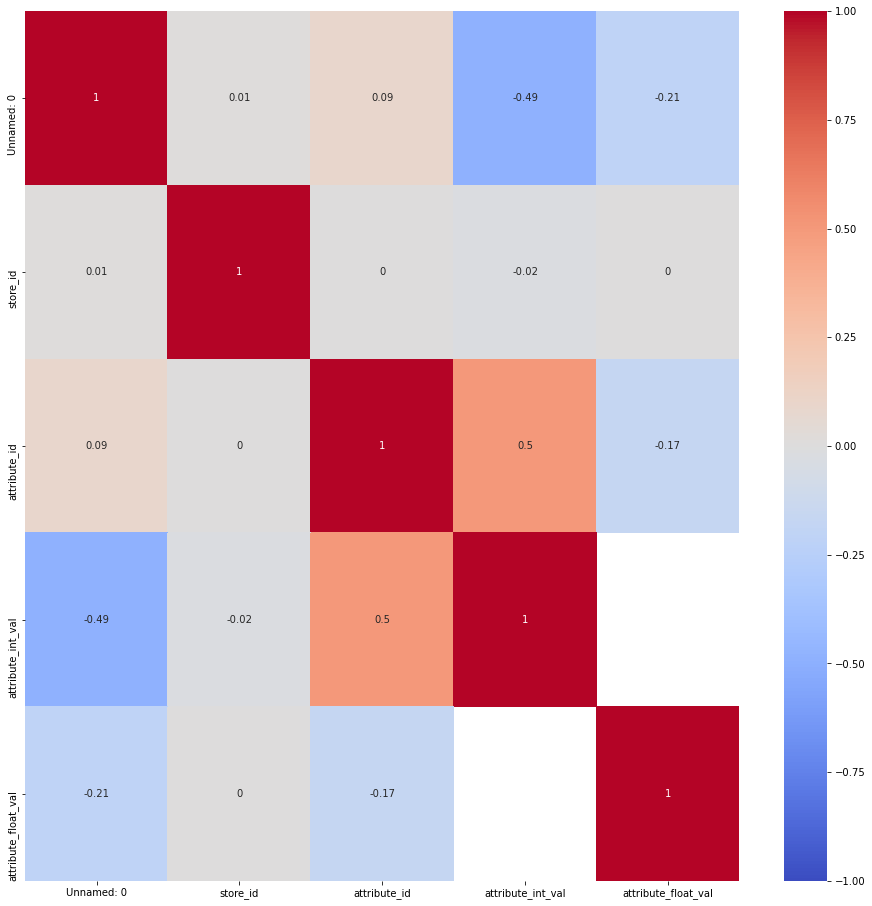

In [40]:
plt.figure(figsize = (16,16))
sns.heatmap(np.round(attributes.corr(),2), annot = True, vmin=-1, vmax=1, center=0, cmap='coolwarm')

<AxesSubplot:>

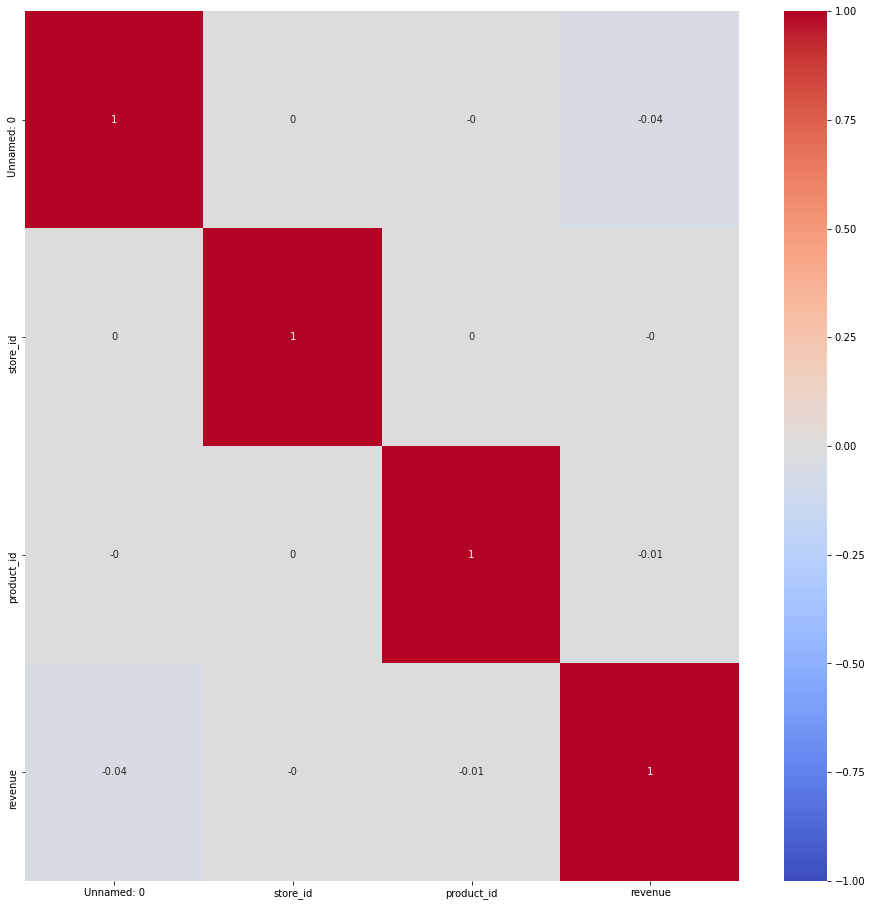

In [41]:
plt.figure(figsize = (16,16))
sns.heatmap(np.round(transaction.corr(),2), annot = True, vmin=-1, vmax=1, center=0, cmap='coolwarm')

In [42]:
transaction.head()

,Unnamed: 0,date_week,store_id,product_id,currency_code,revenue
0,0,2016-07-10,526,31107,USD,3.32
1,1,2016-07-10,526,30772,USD,1.99
2,2,2016-07-10,526,30887,USD,5.32
3,3,2016-07-10,526,31133,USD,6.98
4,4,2016-07-10,526,31118,USD,1.99


In [43]:
len(attributes.attribute_str_val.unique())

358

In [44]:
len(attributes.attribute_int_val.unique())

296

In [45]:
len(attributes.attribute_float_val.unique())

12320

In [46]:
# attributes['attribute_float_val'] = attributes['attribute_float_val'].fillna(attributes['attribute_float_val'].mean())
# attributes['attribute_int_val'] = attributes['attribute_int_val'].fillna(attributes['attribute_int_val'].mean())


In [47]:
# attribute_str = pd.get_dummies(attributes.attribute_str_val)


In [48]:
# attributes.iloc[:,[2,6]]

In [49]:
attributes.groupby(['attribute_id','attribute_type'], group_keys=True).apply(lambda x: x.sample(2)).head(40)



Unnamed: 0  store_id  attribute_id  \
attribute_id attribute_type                                             
1            float          7254         7254       423             1   
                            14909       14909       537             1   
2            float          10975       10975       627             2   
                            8807         8807       603             2   
3            float          3881         3881       415             3   
                            1101         1101       668             3   
4            float          3960         3960       485             4   
                            5347         5347       654             4   
5            float          1881         1881       406             5   
                            5112         5112       616             5   
6            float          11093       11093       633             6   
                            13438       13438       506             6   
7            float          1576         1576       607             7   
                            5730         5730       596             7   
8            float          317           317       596             8   
                            273           273       620             8   
9            string         9596         9596       466             9   
                            9686         9686       479             9   
10           float          13060       13060       410            10   
                            14902       14902       509            10   
11           float          7352         7352       647            11   
                            14589       14589       508            11   
12           float          5943         5943       618            12   
                            4438         4438       420            12   
13           float          12055       12055       605            13   
                            12712       12712       664            13   
14           float          13158       13158       594            14   
                            7191         7191       390            14   
15           string         10473       10473       568            15   
                            9331         9331       535            15   
16           float          4025         4025       354            16   
                            6793         6793       478            16   
17           float          2695         2695       401            17   
                            5856         5856       543            17   
18           float          1373         1373       635            18   
                            2048         2048       473            18   
19           float          4642         4642       431            19   
                            2025         2025       356            19   
20           float          2596         2596       449            20   
                            5468         5468       447            20   

                                  attribute_type  attribute_int_val  \
attribute_id attribute_type                                           
1            float          7254           float                NaN   
                            14909          float                NaN   
2            float          10975          float                NaN   
                            8807           float                NaN   
3            float          3881           float                NaN   
                            1101           float                NaN   
4            float          3960           float                NaN   
                            5347           float                NaN   
5            float          1881           float                NaN   
                            5112           float                NaN   
6            float          11093          float                NaN   
                            13438          fl

In [50]:
attributes[attributes.attribute_id==9]['attribute_str_val'].unique()

array(['ID', 'MT', 'UT', 'NV', 'WY', 'AZ', 'CO', 'WA', 'OR', 'NE', 'SD'],
      dtype=object)

In [51]:
len(a.store_id.unique())

NameError: name 'a' is not defined

In [52]:
len(attributes.store_id.unique())

337

(array([1.4207e+04, 6.2000e+01, 9.8000e+01, 7.1000e+01, 4.3000e+01,
        1.9000e+01, 7.0000e+00, 7.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([-1.19999100e+02,  2.89240192e+06,  5.78492383e+06,  8.67744575e+06,
         1.15699677e+07,  1.44624896e+07,  1.73550115e+07,  2.02475334e+07,
         2.31400553e+07,  2.60325772e+07,  2.89250992e+07]),
 <BarContainer object of 10 artists>)

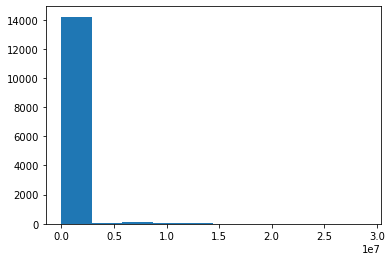

In [53]:
plt.hist(attributes.attribute_float_val)

In [54]:
attributes[attributes.attribute_float_val<0]['attribute_float_val'].count()
attributes[attributes.attribute_float_val>=0]['attribute_float_val'].count()


14182

(array([ 17.,  21.,  34.,  28., 157.,  22.,  26.,   5.,  16.,   8.]),
 array([-119.9991, -118.2889, -116.5787, -114.8685, -113.1583, -111.4481,
        -109.7379, -108.0277, -106.3175, -104.6073, -102.8971]),
 <BarContainer object of 10 artists>)

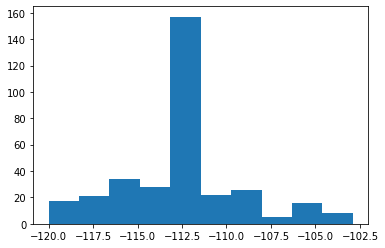

In [55]:
plt.hist(attributes[attributes.attribute_float_val<0]['attribute_float_val'])


In [56]:
#float attribute less than 0 (negative values) # total of 334 rows
print('maximum negative float attribute: ',attributes[attributes.attribute_float_val<0]['attribute_float_val'].max())
print('minimum negative float attribute: ',attributes[attributes.attribute_float_val<0]['attribute_float_val'].min())
print('average negative float attribute: ',attributes[attributes.attribute_float_val<0]['attribute_float_val'].mean())



maximum negative float attribute:  -102.8971
minimum negative float attribute:  -119.9991
average negative float attribute:  -112.33162814371255


In [57]:
#float attribute greater than 0 (positive values) # total 14182 rows

print('maximum positive float attribute: ',attributes[attributes.attribute_float_val>=0]['attribute_float_val'].max())
print('minimum positive float attribute: ',attributes[attributes.attribute_float_val>=0]['attribute_float_val'].min())
print('average positive float attribute: ',attributes[attributes.attribute_float_val>=0]['attribute_float_val'].mean())
print('median positive float attribute: ',attributes[attributes.attribute_float_val>=0]['attribute_float_val'].median())


maximum positive float attribute:  28925099.16
minimum positive float attribute:  0.0
average positive float attribute:  207657.23926570415
median positive float attribute:  2.49


(array([2309., 1607.,  639.,  418.,  501.,  369.,  352.,  328.,  333.,
         235.]),
 array([0.     , 0.24898, 0.49796, 0.74694, 0.99592, 1.2449 , 1.49388,
        1.74286, 1.99184, 2.24082, 2.4898 ]),
 <BarContainer object of 10 artists>)

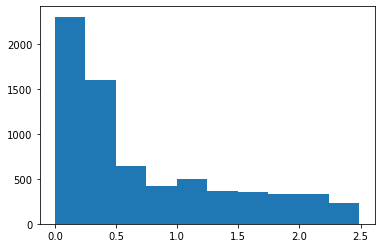

In [58]:
plt.hist(attributes[(attributes.attribute_float_val>=0) & (attributes.attribute_float_val<=2.49)]['attribute_float_val'])



(array([2008.,  391.,  376.,  311.,  339.,   68.,  125.,  266.,  244.,
         303.]),
 array([ 2.4902 , 11.88133, 21.27246, 30.66359, 40.05472, 49.44585,
        58.83698, 68.22811, 77.61924, 87.01037, 96.4015 ]),
 <BarContainer object of 10 artists>)

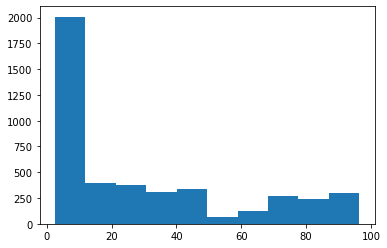

In [59]:
plt.hist(attributes[(attributes.attribute_float_val>2.49) & (attributes.attribute_float_val<=100)]['attribute_float_val'])



In [60]:
attributes[(attributes.attribute_float_val>=100) & (attributes.attribute_float_val<0)]['attribute_float_val'].count()


0

In [61]:
119<x<160 (no data zone)

SyntaxError: invalid syntax (<ipython-input-61-d7b579d0f66b>, line 1)

### Question 3

* **Treatment stores:** 
  * (ids) listed in `q3_treatment_stores.csv`
* **Control stores:** 
  * (ids) listed in `q3_control_stores.csv`

Suppose, also, that we've completed collecting data for the experiment and are using the following time periods:
* **Pre-Test Period:** (X weeks prior to the start of the implementation)
  * 07/17/2016 - 10/15/2016  
* **Implemention Period:** (The period of time needed to actually get get the experiment ready; in this case, the time to put the signs up across all stores)
  * 10/16/2016 - 11/12/2016  
* **Test Period:**  (X weeks after the end of the implementation period)
  * 11/13/2016 - 02/12/2017

How would you quantify the impact of this test on revenue from Brand Z's candy sales? Should we recommend Client X roll out the new signs to all of their stores? 

### Question 3 Approach

Question 3.1: Did Treatment stores have a higher incremental revenue during Test period compared to control stores? (same dates, november to feb)

Question 3.2: Did Treatment stores have a higher incremental revenue during Test period compared to pre test period? (same store impact), only treatment stores but different periods

Question 3.3: Did Treatment stores have a higher incremental revenue during implementation period compare to pre-test period? (buzz impact)

In [63]:
transaction.head()

,Unnamed: 0,date_week,store_id,product_id,currency_code,revenue
0,0,2016-07-10,526,31107,USD,3.32
1,1,2016-07-10,526,30772,USD,1.99
2,2,2016-07-10,526,30887,USD,5.32
3,3,2016-07-10,526,31133,USD,6.98
4,4,2016-07-10,526,31118,USD,1.99


In [64]:
transaction.currency_code.unique()

array(['USD'], dtype=object)

In [65]:
control.count()

0    25
dtype: int64

In [66]:
treatment.count()

0    25
dtype: int64

In [67]:
brandz.head()

,0
0,30898
1,30710
2,30844
3,30900
4,30981


In [68]:
control.head()

,0
0,384
1,511
2,539
3,667
4,643


### Control Stores 

In [69]:
# changing control store column name to 'store_id'

control.columns = ['store_id']
control.columns

Index(['store_id'], dtype='object')

In [70]:
control.head()

,store_id
0,384
1,511
2,539
3,667
4,643


In [71]:
# Control group stores transactions

control_trans = transaction.merge(control, how='inner')
control_trans.head()

,Unnamed: 0,date_week,store_id,product_id,currency_code,revenue
0,194,2016-07-10,384,30874,USD,3.65
1,195,2016-07-10,384,30690,USD,3.65
2,196,2016-07-10,384,31174,USD,3.66
3,197,2016-07-10,384,31107,USD,10.63
4,198,2016-07-10,384,31149,USD,1.99


In [72]:
control_trans.dtypes

Unnamed: 0         int64
date_week         object
store_id           int64
product_id         int64
currency_code     object
revenue          float64
dtype: object

In [73]:
# changing column 'date_week' to datetime 

control_trans['date_week'] = pd.to_datetime(control_trans['date_week'])

In [74]:
control_trans.dtypes

Unnamed: 0                int64
date_week        datetime64[ns]
store_id                  int64
product_id                int64
currency_code            object
revenue                 float64
dtype: object

In [75]:
control_trans.head()

,Unnamed: 0,date_week,store_id,product_id,currency_code,revenue
0,194,2016-07-10,384,30874,USD,3.65
1,195,2016-07-10,384,30690,USD,3.65
2,196,2016-07-10,384,31174,USD,3.66
3,197,2016-07-10,384,31107,USD,10.63
4,198,2016-07-10,384,31149,USD,1.99


In [76]:
# subsetting control group transaction for different dates (pre-test, implementation, test)

control_trans_pre = control_trans[(control_trans.date_week >= '2016-07-17') & (control_trans.date_week <= '2016-10-15')]
control_trans_imp = control_trans[(control_trans.date_week >= '2016-10-16') & (control_trans.date_week <= '2016-11-12')]
control_trans_test = control_trans[(control_trans.date_week >= '2016-11-13') & (control_trans.date_week <= '2017-02-12')]



In [156]:
brandz.columns = ['product_id']

In [176]:
control_trans_pre_noz = pd.merge(control_trans_pre, brandz, on = 'product_id', how = 'outer', indicator = True)
control_trans_pre_noz=control_trans_pre_noz[control_trans_pre_noz['_merge']=='left_only']

control_trans_imp_noz = pd.merge(control_trans_imp, brandz, on = 'product_id', how = 'outer', indicator = True)
control_trans_imp_noz=control_trans_imp_noz[control_trans_imp_noz['_merge']=='left_only']

control_trans_test_noz = pd.merge(control_trans_test, brandz, on = 'product_id', how = 'outer', indicator = True)
control_trans_test_noz=control_trans_test_noz[control_trans_test_noz['_merge']=='left_only']

In [177]:
control_trans_pre_noz.count()

Unnamed: 0       4082
date_week        4082
store_id         4082
product_id       4082
currency_code    4082
revenue          4082
_merge           4082
dtype: int64

In [178]:
control_trans_imp_noz.count()

Unnamed: 0       1208
date_week        1208
store_id         1208
product_id       1208
currency_code    1208
revenue          1208
_merge           1208
dtype: int64

In [179]:
control_trans_test_noz.count()

Unnamed: 0       2805
date_week        2805
store_id         2805
product_id       2805
currency_code    2805
revenue          2805
_merge           2805
dtype: int64

### Treatment Stores

In [77]:
treatment.head()

,0
0,457
1,366
2,431
3,438
4,344


In [78]:
# changing control store column name to 'store_id'

treatment.columns = ['store_id']
treatment.columns

Index(['store_id'], dtype='object')

In [79]:
treatment.head()

,store_id
0,457
1,366
2,431
3,438
4,344


In [80]:
# Treatment group stores transactions

treatment_trans = transaction.merge(treatment, how='inner')
treatment_trans['date_week'] = pd.to_datetime(treatment_trans['date_week'])
treatment_trans.head()

,Unnamed: 0,date_week,store_id,product_id,currency_code,revenue
0,246,2016-07-10,344,30874,USD,10.66
1,247,2016-07-10,344,30690,USD,12.62
2,248,2016-07-10,344,31174,USD,8.65
3,249,2016-07-10,344,30752,USD,1.67
4,250,2016-07-10,344,31107,USD,6.98


In [81]:
treatment_trans.dtypes

Unnamed: 0                int64
date_week        datetime64[ns]
store_id                  int64
product_id                int64
currency_code            object
revenue                 float64
dtype: object

In [112]:
# subsetting control group transaction for different dates (pre-test, implementation, test)

treatment_trans_pre = treatment_trans[(treatment_trans.date_week >= '2016-07-17') & (treatment_trans.date_week <= '2016-10-15')]
treatment_trans_imp = treatment_trans[(treatment_trans.date_week >= '2016-10-16') & (treatment_trans.date_week <= '2016-11-12')]
treatment_trans_test = treatment_trans[(treatment_trans.date_week >= '2016-11-13') & (treatment_trans.date_week <= '2017-02-12')]


In [180]:
treatment_trans_pre_noz = pd.merge(treatment_trans_pre, brandz, on = 'product_id', how = 'outer', indicator = True)
treatment_trans_pre_noz=treatment_trans_pre_noz[treatment_trans_pre_noz['_merge']=='left_only']

treatment_trans_imp_noz = pd.merge(treatment_trans_imp, brandz, on = 'product_id', how = 'outer', indicator = True)
treatment_trans_imp_noz=treatment_trans_imp_noz[treatment_trans_imp_noz['_merge']=='left_only']


In [182]:
treatment_trans_pre_noz.count()

Unnamed: 0       3961
date_week        3961
store_id         3961
product_id       3961
currency_code    3961
revenue          3961
_merge           3961
dtype: int64

In [183]:
treatment_trans_imp_noz.count()

Unnamed: 0       1192
date_week        1192
store_id         1192
product_id       1192
currency_code    1192
revenue          1192
_merge           1192
dtype: int64

In [184]:
treatment_trans_pre.count()

Unnamed: 0       47048
date_week        47048
store_id         47048
product_id       47048
currency_code    47048
revenue          47048
dtype: int64

## Question 3.1: 

## Did Treatment stores have a higher incremental revenue during Test period compared to control stores? (same dates, november to feb)

H0: 

In [186]:
s0 = np.var(control_trans_test_noz['revenue'])
s1 = np.var(treatment_trans_test['revenue'])

print('Control Transaction Test Period Sample Variance:', s0)
print('Treatment Transaction Test Period Sample Variance:', s1)
print('The variances between two samples are not equal, therefore equal_var = False')

Control Transaction Test Period Sample Variance: 13.3260074326659
Treatment Transaction Test Period Sample Variance: 127.7978371087823
The variances between two samples are not equal, therefore equal_var = False


In [187]:
ttest_ind(treatment_trans_test['revenue'], control_trans_test_noz['revenue'], equal_var=False, alternative = 'greater')



Ttest_indResult(statistic=46.127249344319864, pvalue=0.0)

In [101]:
# p value less than 0.05 so we can reject the null hypothesis (no difference btw two groups) 
# and accept alternative hypothesis (the treatment group with Z brand shows higher sales)


## Question 3.2: 

## Did Treatment stores have a higher incremental revenue during Test period compared to pre test period? (same store impact), only treatment stores but different periods

In [188]:
s2 = np.var(treatment_trans_pre_noz['revenue'])
s3 = np.var(treatment_trans_test['revenue'])

print('Treatment Transaction Pre-test Period Sample Variance:', s2)
print('Treatment Transaction Test Period Sample Variance:', s3)
print('The variances between two samples are not equal, therefore equal_var = False')

Treatment Transaction Pre-test Period Sample Variance: 15.624565284727327
Treatment Transaction Test Period Sample Variance: 127.7978371087823
The variances between two samples are not equal, therefore equal_var = False


In [190]:
ttest_ind(treatment_trans_test['revenue'],treatment_trans_pre_noz['revenue'],equal_var=False, alternative = 'greater')



Ttest_indResult(statistic=40.532643496441274, pvalue=0.0)

## Question 3.3: 

## Did Treatment stores have a higher incremental revenue during implementation period compare to pre-test period? (buzz impact)

In [191]:
s4 = np.var(treatment_trans_pre_noz['revenue'])
s5 = np.var(treatment_trans_imp_noz['revenue'])

print('Treatment Transaction Pre-test Period Sample Variance:', s4)
print('Treatment Transaction Implementation Period Sample Variance:', s5)
print('The variances between two samples are not equal, therefore equal_var = False')

Treatment Transaction Pre-test Period Sample Variance: 15.624565284727327
Treatment Transaction Implementation Period Sample Variance: 14.844098248671136
The variances between two samples are not equal, therefore equal_var = False


In [194]:
ttest_ind(treatment_trans_imp_noz['revenue'], treatment_trans_pre_noz['revenue'], equal_var=False)

#there is no difference between two groups

Ttest_indResult(statistic=-2.283102383967704, pvalue=0.022528612765331097)

In [195]:
# Effect size

inc_wo_treatment=control_trans_test_noz['revenue'].mean()-control_trans_pre_noz['revenue'].mean()
inc_wo_treatment

-0.5978641477169262

In [196]:
inc_w_treatment=treatment_trans_test['revenue'].mean()-treatment_trans_pre_noz['revenue'].mean()
inc_w_treatment

3.60712776291541

In [200]:
true_impact = (inc_w_treatment - np.abs(inc_wo_treatment))/np.abs(inc_wo_treatment)*100
true_impact

503.33568699344306

In [ ]:
# 503.34% increase in revenue due to Brand Z candies

___

___